<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/patient_image.png" width="30%" align="right"/>

# Predicting Hospital Readmission with a Binary Classification Model

In this tutorial, we'll be looking at hospital admission data in patients with diabetes. This dataset was collected from 130 hospitals in the United States from 1999 to 2008. More details can be found on the UCI Machine Learning Repository [website](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

This walkthrough is divided into two parts:

- **Data preprocessing (Steps 1-5)**, which involves data cleaning, exploration, and feature engineering
- **Data modelling (Steps 6-10)**, where we will train a machine learning model to predict whether a patient will be readmitted to the hospital

## Data Preprocessing

### Step 1: Importing Depedencies

Before getting started, we'll need to import several packages. These include:

- [pandas](https://pandas.pydata.org/pandas-docs/stable/) - a package for performing data analysis and manipulation
- [numpy](https://docs.scipy.org/doc/numpy/) - a package for scientific computing 
- [matplotlib](https://matplotlib.org/) - the standard Python plotting package
- [seaborn](https://seaborn.pydata.org/) - a dataframe-centric visualization package that is built off of **matplotlib**

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load the Data

We will be loading in the data as a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

The data is stored in a csv file, which we can access locally (see data/patient_data.csv) or in the cloud (stored in a AWS S3 bucket). We'll import the S3 version of this data using a pandas method called `read_csv`.

In [3]:
data = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/diabetes/patient_data.csv")

To get a glimpse of our data, we can use either the `head()`, which shows the first 5 rows of the dataframe.

In [4]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,time_in_hospital,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,3,NaN,...,No,No,Up,No,No,No,No,No,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,2,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,2,NaN,...,No,No,Up,No,No,No,No,No,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,1,NaN,...,No,No,Steady,No,No,No,No,No,Yes,NO


#### How many rows and columns are in our dataset?

In [5]:
data.shape

(101766, 44)

Our dataset has 101,766 rows and 45 columns. Each row represents a unique hospital admission. Columns represent patient demographics, medical details, and admission-specific information such as length of stay (`time_in_hospital`). We can see a list of all columns by applying `.columns` to our dataframe.

In [6]:
print(f"Columns: {data.columns.tolist()}")

Columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed', 'readmitted']


Looking at the columns, we can see that a large proportion are medication names. Let's store these column names as a separate list, which we'll get back to in a bit.

In [7]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

print(f"There are {len(medications)} medications represented as columns in the dataset.")

There are 23 medications represented as columns in the dataset.


#### How many hospital admissions and unique patients are in the dataset? 

In [8]:
n_admissions = data['encounter_id'].nunique()
n_patients = data['patient_nbr'].nunique()

print(f"Number of hospital admissions: {n_admissions:,}")
print(f"Number of unique patients: {n_patients:,}")

Number of hospital admissions: 101,766
Number of unique patients: 71,518


#### How many patients have had more than one hospital admission?

In [9]:
admissions_per_patient = data['patient_nbr'].value_counts().reset_index()
admissions_per_patient.columns = ['patient_nbr', 'count']
multiple_admissions = admissions_per_patient[admissions_per_patient['count'] > 1]

In [10]:
print(f"Proportion of patients that have multiple admissions: {multiple_admissions['patient_nbr'].nunique()/n_patients:.2%}")
print(f"Maximum number of admissions for a given patient: {multiple_admissions['count'].max()}")

Proportion of patients that have multiple admissions: 23.45%
Maximum number of admissions for a given patient: 40


Almost one-quarter of the patients (23.45%) have had more than 1 hosptial admission. The maximum number of hospital admissions for a given patient is 40. 

### Step 3: Data Cleaning

Data cleaning is a crucial step in the machine learning pipeline, and typically requires the most time and effort in any data science project.

#### Decoding Admission Type

The `admission_type_id` column describes the type of admission and is represented by integers. The `id` column links to descriptors found in a separate file. We'll update this column so that it represents the descriptor name instead of simply the id number.

Our mapper files are located in `data/id_mappers/`. They are also stored on the cloud in a AWS S3 bucket.

In [11]:
admission_type = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/diabetes/id_mappers/admission_type_id.csv")
admission_type

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


We can see that the admission type mapper file has 3 values which represent missing data:

1. NaN
2. 'Not Mapped'
3. 'Not Available'

Let's collapse these into one category that represents a missing value. We can use `pandas` [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html) method to do this. 

In [12]:
missing_values = ['nan', 'Not Available', 'Not Mapped']
admission_type['description'] = admission_type['description'].replace(missing_values, np.nan)

In [13]:
admission_type.columns = ['admission_type_id', 'admission_type']

In [14]:
data = data.merge(admission_type, on='admission_type_id')

Now that we have a "clean" mapper, we can apply it to our dataset. We can [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html) `admission_type_id` values in our original dataframe to the descriptors in our `admission_type_mapper` dictionary.

In [15]:
data['admission_type'].value_counts()

Emergency        53990
Elective         18869
Urgent           18480
Trauma Center       21
Newborn             10
Name: admission_type, dtype: int64

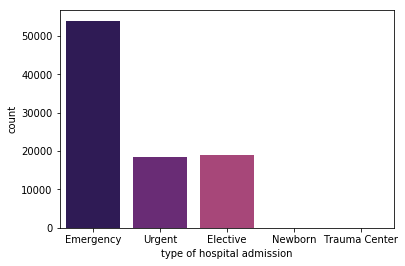

In [16]:
sns.countplot(x='admission_type', data=data, palette='magma')
plt.xlabel('type of hospital admission')
plt.show()

#### Decoding Discharge Location

In [17]:
discharge_disposition = pd.read_csv("https://s3.us-east-2.amazonaws.com/explore.datasets/diabetes/id_mappers/discharge_disposition_id.csv")
discharge_disposition.sample(n=5, random_state=416)

,discharge_disposition_id,description
13,14,Hospice / medical facility
8,9,Admitted as an inpatient to this hospital
14,15,Discharged/transferred within this institution...
20,21,"Expired, place unknown. Medicaid only, hospice."
29,29,Discharged/transferred to a Critical Access Ho...


In medicine, "expired" is a term that describes a patient who has died. We only want to predict hospital readmission for living patients so we're going to remove hospital admissions in which the patient was recorded as "expired" upon being discharged in our dataset.

We'll first convert our `description` column to lowercase (`str.lower()`), then we'll search for rows that contain "expired" (`str.contains("expired")`). 

In [18]:
discharge_disposition['expired'] = discharge_disposition['description'].str.lower().str.contains('expired')

Now let's take a look at all discharge dispositions that indicate an expired patient. We'll create a new dataframe that filters for rows in which the expired column is True.

In [19]:
discharge_expired = discharge_disposition[discharge_disposition['expired']==True]
discharge_expired

,discharge_disposition_id,description,expired
10,11,Expired,True
18,19,"Expired at home. Medicaid only, hospice.",True
19,20,"Expired in a medical facility. Medicaid only, ...",True
20,21,"Expired, place unknown. Medicaid only, hospice.",True


In [20]:
expired_ids = discharge_expired['discharge_disposition_id'].tolist()
print(f"discharge_disposition_id's that indicate an expired patient: {expired_ids}")

discharge_disposition_id's that indicate an expired patient: [11, 19, 20, 21]


The next step is to remove all rows in our original dataset that has `discharge_disposition_id` equal to one of the values in our `expired_ids` list.

In [21]:
data = data[~data['discharge_disposition_id'].isin(expired_ids)]

After removing expired patients, how many patients do we have in our dataset?

In [22]:
n_patients_nonexpired = data['patient_nbr'].nunique()
print(f"Original number of patients: {n_patients:,}")
print(f"Number of expired patients: {n_patients-n_patients_nonexpired:,}")
print(f"After filtering out expired patients: {n_patients_nonexpired:,}")

Original number of patients: 71,518
Number of expired patients: 1,079
After filtering out expired patients: 70,439


We had 1,079 expired patients in our dataset. After removing them, our dataset has 70,439 patients.

#### Converting Medication Features From Categorical to Boolean

Remember that list of medications we created when we loaded our data in Step 2? We're going to convert these medication columns into boolean variables.

In [23]:
data[medications[0]].value_counts()

No        80216
Steady    18256
Up         1067
Down        575
Name: metformin, dtype: int64

Medication columns are currently categorical datatypes that have several possible categories including:

- "No" (not taking the medication)
- "Up" (increased medication dose)
- "Down" (decrease medication dose)
- "Steady" (no changes in dose)

To keep things simple, we'll update the column to "0" (not taking the medication) to "1" (taking the medication). We're losing out on information regarding their dose change, but it's a compromise we're willing to make in order to simplify our dataset.

We can use [numpy.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) to convert all instances of "No" to `0` and everything else (i.e., "Up", "Down", "Steady") to `1`. Let's loop through all medications and convert each column to boolean.

In [24]:
for m in medications:
    data[f'{m}_bool'] = np.where(data[m]=='No', 0, 1)
    data = data.drop(columns=m)

Our medication data are now represented as boolean features. Let's take a look at the prevalence of these medications. We'll calcualte the proportion of patients taking each type of medication. Because some patients have had multiple hospital admissions in this dataset, we'll need to do some wrangling to determine whether a patient was on a given medication during any of their admissions. The wrangling process consists of the following steps:

- applying `groupby` to `patient_nbr` and calculate the sum of admissions in which the patient was administered a medication
- convert the column to boolean such that patients that have "0" are False and "1" is True
- calculate the sum of patients on that specific medication
- calculate the proportion of patients who were administered that medication

In [25]:
prevalence = []

for m in medications:
    patient_meds = data.groupby('patient_nbr')[f'{m}_bool'].sum().reset_index()
    patient_meds[f'{m}_bool'] = patient_meds[f'{m}_bool'].astype(bool)
    n_patients_on_med = patient_meds[f'{m}_bool'].sum()
    proportion = n_patients_on_med/n_patients
    prevalence.append(proportion)

Now that we have a list of medication prevalence, we can create a dataframe and sort by prevalence to determine which medications are most prevalent in our dataset. 

In [26]:
medication_counts = pd.DataFrame({'medication': medications, 'prevalence':prevalence})
medication_counts = medication_counts.sort_values(by='prevalence', ascending=False)
medication_counts.head()

,medication,prevalence
17,insulin,0.543779
0,metformin,0.229523
6,glipizide,0.138916
7,glyburide,0.118851
9,pioglitazone,0.082525


Let's also visualize the top 10 most prevalent medications. We'll use seaborn's [barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) method.

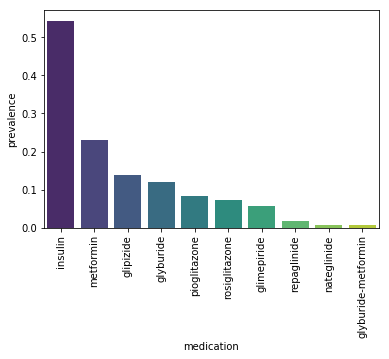

In [27]:
sns.barplot(x='medication', y='prevalence', data=medication_counts.head(10), palette='viridis')
plt.xticks(rotation=90)
plt.show()

We can see that `insulin` is by far the most prevalent medication followed by `metformin`. More than half of the patients in our dataset were prescribed insulin whie 22% were prescribed metformin. 

[MeSH](https://en.wikipedia.org/wiki/Medical_Subject_Headings) (or Medical Subject Headings) are a type of "tag" that describes a medical term. We'll use RxNav's API to further investigate which MeSH terms are assocaited with our list of medications. We'll cretea a function called `get_mesh_from_drug_name` which returns relevant MeSH terms for a given drug name.

In [28]:
import json
import requests

def get_mesh_from_drug_name(drug_name):
    drug_name = drug_name.strip()
    rxclass_list = []
    try:
        r = requests.get(f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byDrugName.json?drugName={drug_name}&relaSource=MESH")
        response = r.json()
        all_concepts = response['rxclassDrugInfoList']['rxclassDrugInfo']
        for i in all_concepts:
            rxclass_list.append(i['rxclassMinConceptItem']['className'])
    except:
        pass
    return list(set(rxclass_list))

We'll pass the top 10 medications into `get_mesh_from_drug_name` and get their relevant MeSH terms. The results will be stored in a dictionary that we'll call `med_mesh_descriptors`.

In [29]:
top_ten_meds = medication_counts.head(10)['medication'].tolist()

med_mesh_descriptors = dict()
for m in top_ten_meds:
    med_mesh_descriptors[m] = get_mesh_from_drug_name(m)

In [30]:
med_mesh_descriptors

{'insulin': [],
 'metformin': ['Hypoglycemic Agents'],
 'glipizide': ['Hypoglycemic Agents'],
 'glyburide': ['Hypoglycemic Agents'],
 'pioglitazone': ['Hypoglycemic Agents'],
 'rosiglitazone': ['Hypoglycemic Agents'],
 'glimepiride': ['Immunosuppressive Agents',
  'Hypoglycemic Agents',
  'Anti-Arrhythmia Agents'],
 'repaglinide': ['Hypoglycemic Agents'],
 'nateglinide': ['Hypoglycemic Agents'],
 'glyburide-metformin': ['Hypoglycemic Agents']}

The results above show that all medications have the MeSH term [hypoglycemic agent](https://en.wikipedia.org/wiki/Anti-diabetic_medication), which means it's an anti-diabetic medication. Interestingly, the medication `glimepiride` also has two other associated MeSH terms 'Anti-Arrhythmia Agents' and 'Immunosuppressive Agents' in addition to it being a hypoglycemic agent.

If you want to learn more about each medication in our dataset, check out the [RxNav dashboard](https://mor.nlm.nih.gov/RxNav/) which gives an overview of medication properties and interactions.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/rxnav_dashboard.png" width="70%"/>

#### Creating a Target Variable

The goal of our model will be to predict whether a patient will get readmitted to the hospital. Looking at the `readmitted` column, we see that there are 3 possible values: 

1. `NO` (not readmitted)
2. `>30` (readmitted more than 30 days after being discharged)
3. `<30` (readmitted within 30 days of being discharged)

In [31]:
data['readmitted'].value_counts()

NO     53212
>30    35545
<30    11357
Name: readmitted, dtype: int64

To keep things simple, we'll view this as a binary classification problem: did the patient get readmitted? We're going to use `numpy.where` to convert all instances of "NO" to 0 (means patient did not get readmitted) and everyhting else to 1 (patient did get readmitted).

In [32]:
data['readmitted_bool'] = np.where(data['readmitted']=='NO', 0, 1)
data['readmitted_bool'].value_counts()

0    53212
1    46902
Name: readmitted_bool, dtype: int64

### Step 4: Data Exploration and Visualization

#### Assessing Missing Values

To get a better sense of the missing values in our data, let's visualize it using [missingno](https://github.com/ResidentMario/missingno)'s "nullity" matrix.

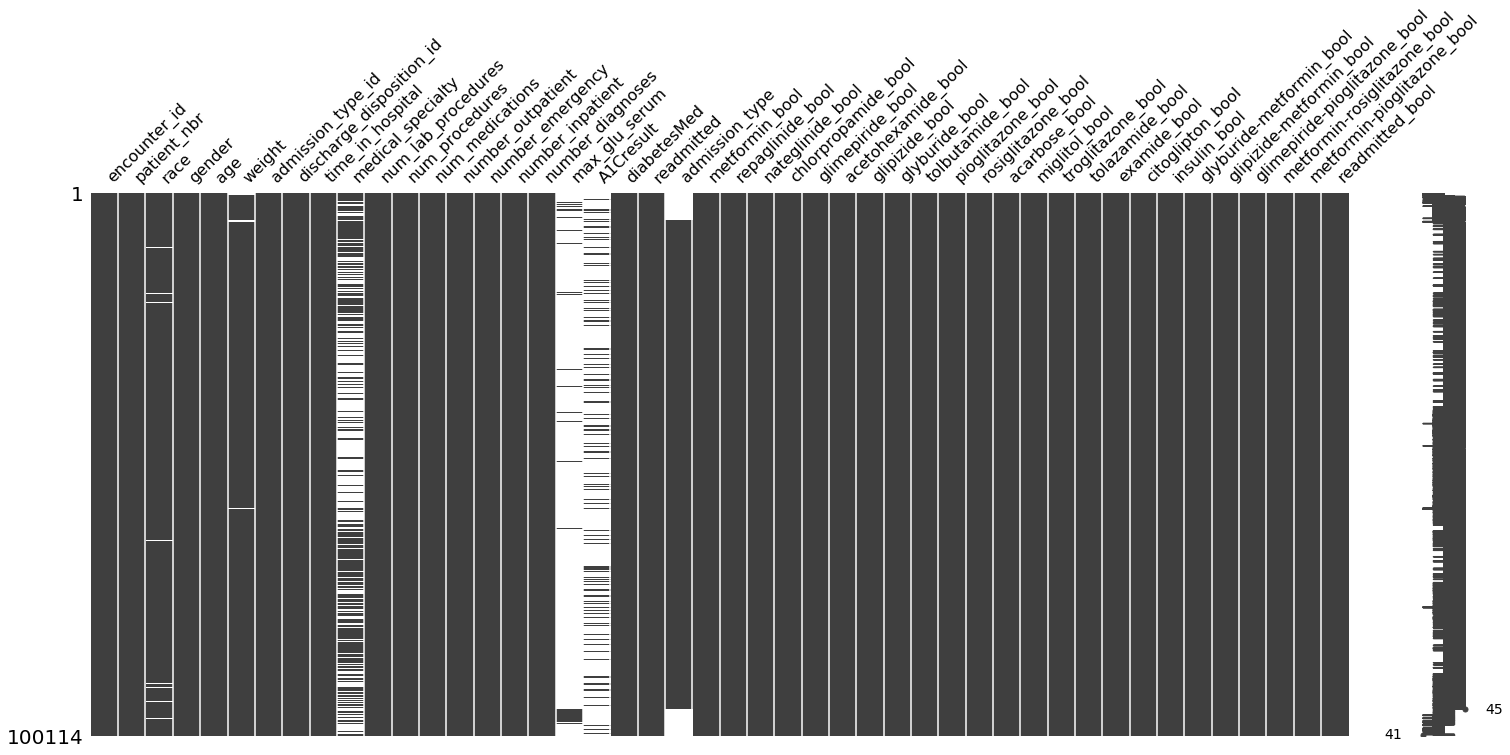

In [33]:
import missingno as msno

msno.matrix(data)

The data-dense columns are fully black, while the sparse columns (with missing values) have a mixture of white and black. 

#### Patient Demographics: Age and Gender

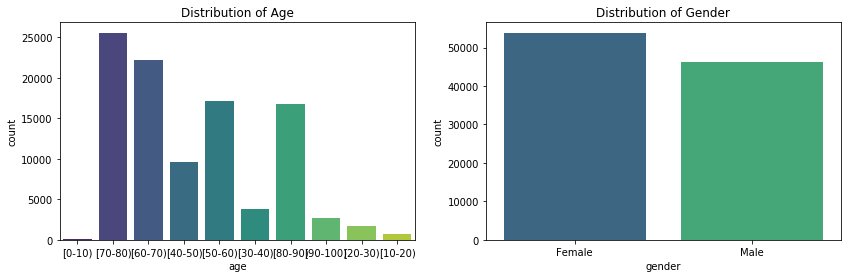

In [34]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.countplot(x='age', data=data, palette='viridis')
plt.title("Distribution of Age")

plt.subplot(1,2,2)
sns.countplot(data['gender'], palette='viridis')
plt.title("Distribution of Gender")
plt.show()

In [35]:
data['gender'].value_counts(normalize=True)

Female    0.538013
Male      0.461987
Name: gender, dtype: float64

The age distribution plot shows that our dataset represents an aging population. The most common age range is 70-80 years old. Our population also has a higher proportion of females than males.

#### How long were hospital stays for a given admission?

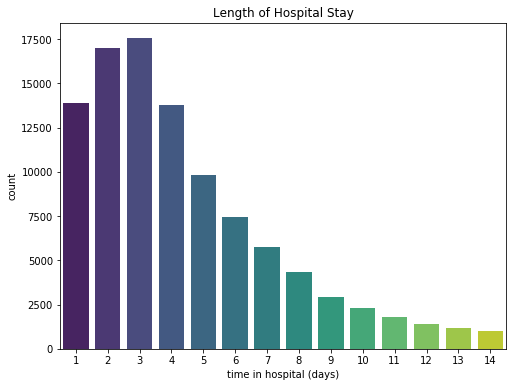

In [36]:
plt.figure(figsize=(8,6))
sns.countplot(data['time_in_hospital'], palette='viridis')
plt.xlabel("time in hospital (days)")
plt.title("Length of Hospital Stay")
plt.show()

In [37]:
print(f"Mean time in hospital: {data['time_in_hospital'].mean():.2f}")

Mean time in hospital: 4.39


Patients stayed on average 4.4 days in hospital. The longest stay was 14 days.

#### Number of Diagnoses, Procedures, Medications

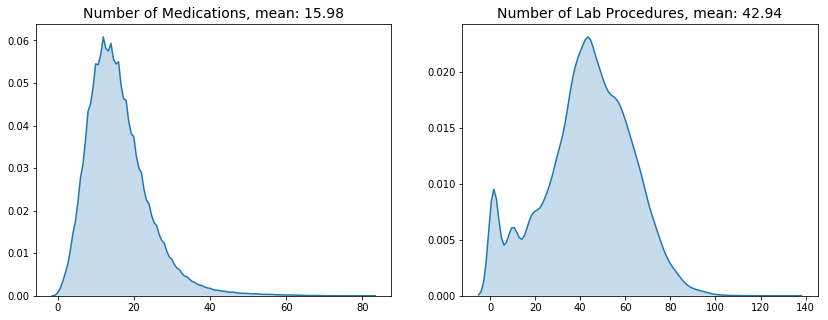

In [38]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.kdeplot(data['num_medications'], shade=True, legend=False)
plt.title(f"Number of Medications, mean: {data['num_medications'].mean():.2f}", size=14)

plt.subplot(1,2,2)
sns.kdeplot(data['num_lab_procedures'], shade=True, legend=False)
plt.title(f"Number of Lab Procedures, mean: {data['num_lab_procedures'].mean():.2f}", size=14)
plt.show()

Patients on average were administered 16 medications during their hospital stay. The average number of lab procedures was 43.

#### What was the most common medical specialty?

We also have information on the medical specialty of a patient's attending physician. This can give us a sense of the nature of a patient's illness during their hospital stay. For example, "orthopedics" would suggest that the patient's presenting issue was bone-related, while "nephrology" suggests a kidney problem.

In [39]:
medical_specialties = data['medical_specialty'].value_counts().reset_index()
medical_specialties.columns = ['specialty', 'count']
medical_specialties['prevalence'] = medical_specialties['count']/len(data)
print(f"There are {data['medical_specialty'].nunique()} medical specialties.")
medical_specialties.head(10)

There are 72 medical specialties.


,specialty,count,prevalence
0,InternalMedicine,14328,0.143117
1,Emergency/Trauma,7449,0.074405
2,Family/GeneralPractice,7302,0.072937
3,Cardiology,5296,0.052900
4,Surgery-General,3068,0.030645
5,Nephrology,1544,0.015422
6,Orthopedics,1394,0.013924
7,Orthopedics-Reconstructive,1231,0.012296
8,Radiologist,1129,0.011277
9,Pulmonology,856,0.008550


#### What proportion of patients were on diabetes medication during their hospital stay?

In [40]:
data['diabetesMed'].value_counts(normalize=True)

Yes    0.77184
No     0.22816
Name: diabetesMed, dtype: float64

77% of patients were on diabetes medication during their stay.

#### Do patients have normal A1C levels?

The A1C blood test is used to diagnose whether a patient has type I or II diabetes, and represents the average levels of blood sugar over the past 3 months. The higher the A1C level, the poorer a patient's blood sugar control which indicates a higher risk of diabetes complications. The table below represents Mayo Clinic's [guideline](https://www.mayoclinic.org/tests-procedures/a1c-test/about/pac-20384643) of how to interpret A1C levels:

|interpretation|A1C level|
|-----------|--------|
|no diabetes|<5.7|
|pre-diabetes|5.7-6.4|
|diabetes|>6.5|
|well-managed diabetes|<7|
|poorly managed diabetes|>8|

Our dataset has a `A1Cresult` which reflects a patient's A1C level during their hospital stay. 

In [41]:
data['A1Cresult'].value_counts(normalize=True)

>8      0.482994
Norm    0.292783
>7      0.224224
Name: A1Cresult, dtype: float64

In [42]:
print(f"Proportion of hospital admissions with missing A1C result: {data['A1Cresult'].isna().sum()/len(data):.2%}")

Proportion of hospital admissions with missing A1C result: 83.14%


Of the hospital admissions where A1C was measured, almost half had a A1C level of greater than 8, which suggests that the patient's diabetes was poorly managed. However, the availability of A1C data is sparse in our dataset, so we may want to consider not including it in the first iteration of our model.

### Step 5: Feature Selection and Engineering

Our dataset contains quite a few categorical variables such as `race`, `age`, and `admission_type`. In general, machine learning models can't handle categorical variables so we can use one-hot and label encoding to convert our string features to numerical without adding a hierarchy. 

#### One-hot Encoding

Let's say we want to convert a patient's race to a numerical feature. We could use label encoding to convert each race to values 0-5 but this suggests an inherent order among races that does not exist. With one-hot encoding, each race becomes an independent feature.

In [43]:
categorical = ['race', 'admission_type']

for c in categorical:
    data = pd.concat([data, pd.get_dummies(data[c], prefix=c)], axis=1)
    data.drop(columns=c)

In [44]:
data['age'].value_counts()

[70-80)     25562
[60-70)     22185
[50-60)     17102
[80-90)     16706
[40-50)      9626
[30-40)      3765
[90-100)     2668
[20-30)      1650
[10-20)       690
[0-10)        160
Name: age, dtype: int64

#### Label Encoding

There are a couple of features where label encoding is applicable. 

- age (from `[0-10)` to `[70-80)`) can assume an ordinal relationship
- gender (`Male` or `Female`) converts to 0 and 1 which is binary

Let's go ahead and apply scikit-learn's [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to these two columns.

In [45]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['age_label'] = label_encoder.fit_transform(data['age'])
data['gender_bool'] = label_encoder.fit_transform(data['gender'].astype(str))

Because our `gender` column contained some missing values, it was considered to be a mixed datatype. We had to convert it to a string datatype in order to label encoding to work.

## Data Modelling

### Step 6: Defining the X and y Variables

Given that we now have a good understanding of our dataset, we can now aim to build predictive models. The first step is to separate our features and target into variables `X` and `y` respectively.

In [46]:
med_features = ['metformin_bool', 'repaglinide_bool',
    'nateglinide_bool', 'chlorpropamide_bool', 'glimepiride_bool',
    'acetohexamide_bool', 'glipizide_bool', 'glyburide_bool',
    'tolbutamide_bool', 'pioglitazone_bool', 'rosiglitazone_bool',
    'acarbose_bool', 'miglitol_bool', 'troglitazone_bool',
    'tolazamide_bool', 'examide_bool', 'citoglipton_bool', 'insulin_bool',
    'glyburide-metformin_bool', 'glipizide-metformin_bool',
    'glimepiride-pioglitazone_bool', 'metformin-rosiglitazone_bool',
    'metformin-pioglitazone_bool']

demographic_features = ['race_AfricanAmerican', 'race_Asian',
    'race_Caucasian', 'race_Hispanic', 'race_Other', 'age_label',
    'admission_type_Elective', 'admission_type_Newborn',
    'admission_type_Trauma Center', 'admission_type_Urgent', 'gender_bool']

other_features = ['num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']

all_features = med_features + demographic_features + other_features

X = data[all_features]
y = data['readmitted_bool']

### Step 7: Choosing our Model

When building a binary classification model, there are a wide selection of machine learning models to choose from:

- Random Forest Classification
- Logistic Regression
- Linear Discriminant Analysis
- Support Vector Machines (SVM)
- Gaussian Naive Bayes
- k-Nearest Neighbours

We'll test out the [Random Forest Classifier (RFC)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for this dataset. RFC is an ensemble learning technique that works by creating a "forest" of decision trees. Each tree evaluates the data for a given patient and outputs a 0 or 1. Random Forest looks at the output of all trees and gives the majority vote as its result. Let's say we have a forest with 3 trees and 2 of them predict the patient will be readmitted. The majority vote is that the patient will be readmitted.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/random_forest.png" width="70%"/>

We're choosing Random Forest because:

- it is robust to outliers
- it is able to handle unbalanced datasets 
- it measures feature importance

We'll import RFC from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) which is a very comprehensive Python library for data mining and data analysis.

In [47]:
from sklearn.ensemble import RandomForestClassifier

We can inspect the default parameters for RandomForestClassifier by creating an instance of the class and applying `get_params()`:

In [48]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

You can keep the default values for most of these parameters. But there are a few that can be modified prior to training the model that can impact model performance. These are called [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Some RFC hyperparameters include:

- `n_estimators`: number of trees in the forest
- `max_depth`: maximum number of levels in each decision tree
- `max_features`: maximum number of features considered for splitting a node
- `min_samples_split`: number of data points placed in a node before the node is split 

These are external configurations that can't be learned from training the model. To select the optimal values of a hyperparameter, we'll need to use a technique called hyperparameter tuning. 

### Step 8: Hyperparameter Tuning

Hyperparemter tuning is a critical step in the machine learning pipeline. It describes the process of choosing a set of optimal hyperparameters for a model. The hyperparameters that you select can have a significant impact on your model's performance. 

We're going to be testing out two hyperparameter tuning techniques offered by scikit-learn:

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/grid_search.png" align="right" width="20%"/>

With grid search, you define your search space as a grid of values and iterate over each grid point until you find the optimal combination of values. Let's say we want to tune `max_depth` and `n_estimators` in our RandomForestClassifer. We'll set our search space as follows:

- n_estimators = [5,10,50]
- max_depth = [3,5,10]

This means that we'll have to train our model 9 times to test for every configuration of values. We'll choose the combination of n_estimators and max_depth that give us the best model performance.

Let's implement this with scikit-learn's GridSearchCV. We first need to define our search space as a dictionary. We also need to initialize our model.

In [49]:
from sklearn.model_selection import GridSearchCV

search_space = {
    'n_estimators': [5,10,50],
    'max_depth': [3,5,10]
}

rfc = RandomForestClassifier(random_state=42)

Now, we set up grid search. GridSearchCV also performs [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) (hence the `'CV'`) so we can specify how many folds we want in our analysis. We'll set our number of folds to 3. The more folds you use, the longer it will take to compute results.

In [50]:
grid_search = GridSearchCV(rfc, search_space, cv=3)

The last step is to run fit. We'll pass in X and y which we created in *Step 6*. GridSearchCV will use RFC's default metric, [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score). If we want to optimize our model using another metric, we can specify `scoring = 'precision'` (or whichever metric we're interested in) inside GridSearchCV. Let's stick with accuracy for now.

In [51]:
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 50], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

What are the optimal hyperparameters?

In [52]:
print(f"Optimal hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Optimal hyperparameters: {'max_depth': 5, 'n_estimators': 50}
Best score: 0.617


Based on the search space we defined for GridSearchCv, it looks like max_depth of 5 and n_estimators of 50 are our optimal hyperparmeters which gave us an accuracy of 0.617. 

We can also see a thorough report of our results with `cv_results_`. It shows fit time, score time, and mean train/test score (averaged over all folds). We'll sort by `mean_test_score`.

In [53]:
results = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,1.132375,0.009537,0.121620,0.001741,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.609014,0.633214,0.608373,0.616867,0.011562,1,0.633694,0.621683,0.627437,0.627605,0.004905
2,0.821872,0.007762,0.100330,0.000355,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.600264,0.627461,0.613047,0.613591,0.011110,2,0.624509,0.611839,0.619121,0.618490,0.005192
8,1.907094,0.071164,0.202362,0.028745,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.610332,0.621767,0.606814,0.612971,0.006383,3,0.655344,0.647828,0.647259,0.650144,0.003685
4,0.251050,0.008086,0.035588,0.000535,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.606107,0.624554,0.596686,0.609116,0.011574,4,0.631596,0.615375,0.622912,0.623294,0.006628
7,0.399570,0.004194,0.045592,0.000699,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.609553,0.614216,0.601510,0.608426,0.005248,5,0.654161,0.644068,0.642195,0.646808,0.005255


In 2012, Bergstra and Bengio from the University of Montreal proposed a new technique called [random search](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) which is similar to grid search but instead of sampling over a discrete set of values, you’re now randomly sampling from a distribution of values. Random search is effective in situations where not all hyperparameters are equally important.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/random_grid_search.png"/>

The visualization above gives an example of when random search can perform better. With grid search, you’re only looking at 3 different values of a given hyperparamter. But with random search you’re looking at nine different values. As you increase the number of samples in your random search, you increase the probability of finding the optimal hyperparameters for your model. 

Let's test out random search using scikit-learn's RandomizedSearchCV. We'll define our search space over a uniform distribution of values. We'll iterate 9 times, just like we did for grid search. 

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

search_space = {
    "n_estimators": randint(10,100),
    "max_depth": randint(1, 11)
}

random_search = RandomizedSearchCV(rfc, param_distributions=search_space, n_iter=9, cv=3)
random_search.fit(X,y)

print(f"Optimal hyperparameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.3f}")

Optimal hyperparameters: {'max_depth': 4, 'n_estimators': 59}
Best score: 0.615


In [55]:
results = pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
7,1.149746,0.021392,0.129111,0.002811,4,59,"{'max_depth': 4, 'n_estimators': 59}",0.606107,0.629858,0.609841,0.615269,0.010428,1,0.629873,0.614746,0.624890,0.623170,0.006294
0,1.136515,0.057328,0.126526,0.004007,4,58,"{'max_depth': 4, 'n_estimators': 58}",0.605178,0.630068,0.609152,0.614799,0.010918,2,0.629634,0.614791,0.625174,0.623200,0.006218
1,2.200676,0.430752,0.166357,0.003467,6,65,"{'max_depth': 6, 'n_estimators': 65}",0.609853,0.623895,0.609691,0.614479,0.006658,3,0.636511,0.625938,0.630029,0.630826,0.004353
6,2.004584,0.041066,0.205204,0.006243,6,80,"{'max_depth': 6, 'n_estimators': 80}",0.610362,0.622247,0.608313,0.613640,0.006143,4,0.636661,0.626223,0.630313,0.631066,0.004294
4,2.834532,0.151390,0.263107,0.004990,9,77,"{'max_depth': 9, 'n_estimators': 77}",0.610152,0.623925,0.606125,0.613401,0.007621,5,0.648422,0.641221,0.641520,0.643721,0.003326


Grid Search and Random Search are uninformed methods which means that they do not take into consideration results from past evaluations. When you're working with a very large search space, you might want to consider a "smarter" approach to hyperparameter tuning such a Sequential-Based Model Optimization (SMBO). The SMBO approach keeps track of previous iteration results which is used to sample hyperapramters at the current iteration. In other words, SMBO is trying to reduce the number of iterations by sampling the most promising hyperparameters based on past results. You can check out [scikit-optimize](https://scikit-optimize.github.io/) to learn more about how to implement SMBO hyperparameter tuning with scikit-learn models. 

### Step 9: Evaluating Model Performance

There are several metrics that we can use to evaluate model performance:

- accuracy
- precision
- recall
- F1-score
- ROC AUC score

A comprehensive list of classification metrics can be found in scikit-learn's metrics module [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). 

In this walkthrough, we'll look at accuracy, precision and recall. But before we can start evaluating our model, let's split our data into two parts: 1) a training set and 2) a test set. We'll fit our model on the training data, and evaluate its performance using the test set.

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc = RandomForestClassifier(**random_search.best_params_)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=59, n_jobs=None,
            oob_score=False, random_state=99, verbose=0, warm_start=False)

Accuracy is RFC's default evaluation metric. Using the score metric, we get the measured accuracy from the trained model. 

In [57]:
accuracy = rfc.score(X_test, y_test)

print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.620


An accuracy score of 0.62 means that ~62% of hospital admissions were correctly labeled. The dataset that we're working with is relatively balanced, but let's say we have an imbalanced dataset where 90% of patients ended up being readmitted. Using accuracy to evaluate a model trained on imbalanced data is a problem because if we automatically predicted all patients to be readmitted, our accuracy would be 90% by default. Precision and recall are better ways to evaluate performance of models trained on imbalanced data. 

#### Precision and Recall 

Precision and recall are information retrieval metrics that evaluate classification models. 

- [Precision](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) is the "fraction of relevant instances among the retrieved instances".
    - What proportion of predicted readmitted patients were actually readmitted?
- Recall is the "fraction of the total amount of relevant instances that were actually retrieved".
    - What proportion of readmitted patients were identified correctly?

Looking at the equations below, we can see that precision aims to minimize the number of **False Positives**, while recall aims to minimize the number of **False Negatives**.

<img src="https://s3.us-east-2.amazonaws.com/hidden.layers.assets/precision_recall.png" width="70%"/>

In [58]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_pred = rfc.predict(X_test)

precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Precision: 0.621
Recall: 0.451


- Of the patients who were labelled as readmitted, ~62% were actually readmitted.
- Of the patients who were actually readmitted, 45% were labelled as readmitted. 

Another way to assess our model's performance is to visualize our results with a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

Text(33.0, 0.5, 'actual')

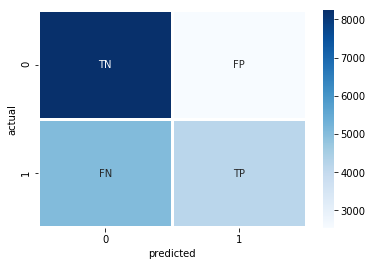

In [59]:
confusion = confusion_matrix(y_true=y_test, y_pred=y_pred)
labels = np.array([['TN','FP'],['FN','TP']])

sns.heatmap(confusion,annot=labels, fmt='', linewidths=2, cmap="Blues")
plt.xlabel("predicted")
plt.ylabel("actual")

The heatmap above shows that we have more False Negatives than False Positives. This means that when we predict a patient will be readmitted, there's a good chance that we got it right. But when we predict that a patient won't be admitted, we're missing quite a few patients who actually do return to the hospital. 

### Step 10: Examining Feature Importance

With RandomForestClassifier, we can dig further to examine which features were the most important in classification.

In [60]:
feature_importances = {
    'features': list(X.columns.values),
    'importance': list(rfc.feature_importances_)
}

important_features = pd.DataFrame(feature_importances)
important_features.sort_values(by='importance', ascending=False).head(15)

,features,importance
39,number_inpatient,0.502475
38,number_emergency,0.145222
37,number_outpatient,0.103304
40,number_diagnoses,0.095260
36,num_medications,0.049601
28,age_label,0.021661
29,admission_type_Elective,0.019275
34,num_lab_procedures,0.018061
35,num_procedures,0.016270
17,insulin_bool,0.009118


The most important feautures appear to be `number_inpatient` and `number_emergency`, which represents the number of inpatient and emergency visits of the patient in the year preceding the encounter. So if a patient was admitted to the hospital in the past, this increases their chance of being readmitted in the future. 